In [12]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as datasets
from torch.autograd import Variable
import torchvision
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [13]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
train_size = int(0.5 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)

In [14]:
from tiny_model_we import Net
from architect_we import Architect

alphas1
alphas2
Train acc 0.7654251066098081
Val acc 0.9333688699360341
Train acc 0.9437300106609808
Val acc 0.9483275586353944
Train acc 0.9576559168443497
Val acc 0.960987473347548
Train acc 0.9629197761194029
Val acc 0.9622867803837953
Train acc 0.9657515991471215
Val acc 0.9633528784648188
Train acc 0.9698160980810234
Val acc 0.9656849680170576
Train acc 0.9712153518123667
Val acc 0.9665178571428571
Train acc 0.9718483475479744
Val acc 0.9640525053304904
Train acc 0.974546908315565
Val acc 0.9643190298507462
Train acc 0.9749466950959488
Val acc 0.9689498933901919
Train acc 0.9778118336886994
Val acc 0.9686500533049041
Train acc 0.9780117270788913
Val acc 0.9717817164179104
Train acc 0.978411513859275
Val acc 0.9711154051172708
Train acc 0.9793443496801706
Val acc 0.9719816098081023
Train acc 0.9802105543710021
Val acc 0.9724147121535182
Train acc 0.9814099147121536
Val acc 0.9706156716417911
Train acc 0.9820429104477612
Val acc 0.9739805437100213
Train acc 0.9816431236673774
Val ac

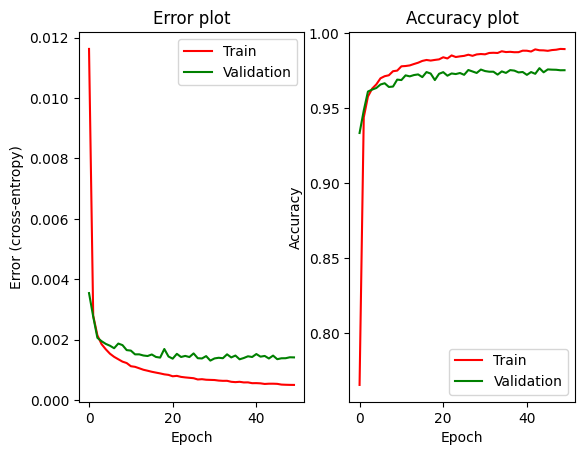

Test accuracy : 0.9779


In [15]:
param_list = []
model = Net(4,4,20,'darts').cuda()
for n,p in model.named_parameters():
    if "alpha" not in n:
        param_list.append(p)
    else:
        print(n)
architect = Architect(model)
optimizer = torch.optim.SGD(param_list,lr=0.1)
criterion = nn.CrossEntropyLoss()
batch_size = 64
train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader)*batch_size
n_val = len(val_loader)*batch_size
tau = torch.Tensor([0.1])
for i in range(50):
  total_loss = 0
  total_acc = 0  
  c = 0
  for (images,labels), (images_val,labels_val) in zip(train_loader,val_loader):
    images = images.cuda()
    labels = labels.cuda()
    images_val = images_val.cuda()
    labels_val = labels_val.cuda()    
    optimizer.zero_grad()
    output = model(images,tau)
    loss = criterion(output,labels)
    loss.backward()
    optimizer.step()
    architect.step(images, labels, images_val, labels_val, 0.1, optimizer, unrolled=True)
    total_loss+=loss.item()
    total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0    
    c+=1
    
  
  #validation
  
  total_loss_val = 0
  total_acc_val = 0
  c = 0
  for images,labels in val_loader:
    images = images.cuda()
    labels = labels.cuda()
    output = model(images,tau)
    loss = criterion(output,labels)
    
    total_loss_val +=loss.item()
    total_acc_val +=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
    c+=1
  train_errors.append(total_loss/n_train)
  train_acc.append(total_acc/n_train)
  val_errors.append(total_loss_val/n_val)
  val_acc.append(total_acc_val/n_val)
  print("Train acc",train_acc[-1])
  print("Val acc",val_acc[-1])  
print("Training complete")

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Error plot")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Accuracy plot")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()

total_acc = 0
for images,labels in test_loader:
  images = images.cuda()
  labels = labels.cuda()
  output = model(images,tau)
  total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0

print("Test accuracy :",total_acc/len(test_loader.dataset))

In [17]:
print(torch.argmax(torch.nn.functional.softmax(model.alphas1,dim=-1)))
print(torch.argmax(torch.nn.functional.softmax(model.alphas2,dim=-1)))

tensor(6, device='cuda:0')
tensor(9, device='cuda:0')


Train acc 0.8969791666666667
Val acc 0.9405751329787234
Train acc 0.9559583333333334
Val acc 0.9542885638297872
Train acc 0.9630208333333333
Val acc 0.9626828457446809
Train acc 0.9663333333333334
Val acc 0.9625997340425532
Train acc 0.9687916666666667
Val acc 0.961186835106383
Train acc 0.9702708333333333
Val acc 0.9680851063829787
Train acc 0.9708125
Val acc 0.9642619680851063
Train acc 0.9727291666666666
Val acc 0.9667553191489362
Train acc 0.9738125
Val acc 0.9654255319148937
Train acc 0.9746458333333333
Val acc 0.9699966755319149
Train acc 0.9756875
Val acc 0.9670046542553191
Train acc 0.9764375
Val acc 0.9681682180851063
Train acc 0.9774583333333333
Val acc 0.9704122340425532
Train acc 0.977375
Val acc 0.9669215425531915
Train acc 0.9776666666666667
Val acc 0.9691655585106383
Train acc 0.9782916666666667
Val acc 0.9685837765957447
Train acc 0.9794791666666667
Val acc 0.9719913563829787
Train acc 0.9792291666666667
Val acc 0.9709109042553191
Train acc 0.9800625
Val acc 0.971326462

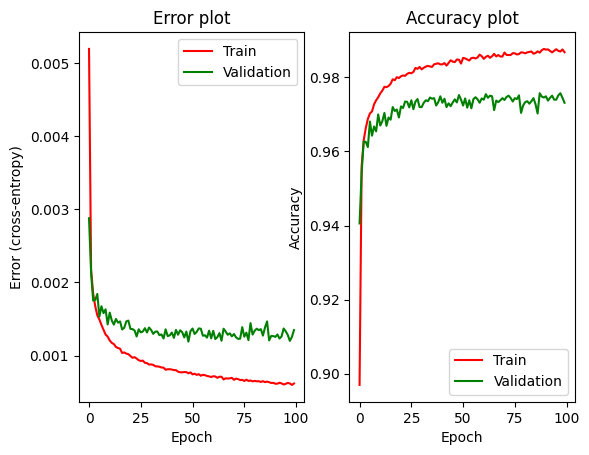

Test accuracy : 0.9792


In [18]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as datasets
from torch.autograd import Variable
import torchvision
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)
dict_test_accs = {}
idx1 = 6
idx2 = 9
from tiny_model import NetDiscrete
model = NetDiscrete(4,4,20,idx1,idx2).cuda()
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
criterion = nn.CrossEntropyLoss()
batch_size = 64
train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader)*batch_size
n_val = len(val_loader)*batch_size
for i in range(100):
    total_loss = 0
    total_acc = 0
    c = 0
    for (images,labels) in train_loader:
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0    
        c+=1
        #validation
        total_loss_val = 0
        total_acc_val = 0
        c = 0
    for images,labels in val_loader:
        images = images.cuda()
        labels = labels.cuda()
        output = model(images)
        loss = criterion(output,labels)
        total_loss_val +=loss.item()
        total_acc_val +=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
        c+=1
    train_errors.append(total_loss/n_train)
    train_acc.append(total_acc/n_train)
    val_errors.append(total_loss_val/n_val)
    val_acc.append(total_acc_val/n_val)
    print("Train acc",train_acc[-1])
    print("Val acc",val_acc[-1])
print("Training complete")
print(idx1,idx2)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Error plot")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Accuracy plot")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()
total_acc = 0
for images,labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    output = model(images)
    total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
print("Test accuracy :",total_acc/len(test_loader.dataset))
test_acc = total_acc/len(test_loader.dataset)
dict_test_accs[(idx1,idx2)]= test_acc